In [28]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAUROC

In [22]:
from zambia_train import Core2MapModel, ShardDataset, compute_fss

In [23]:
LEAD_TIME = "1"
BASE_DIR = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/preprocessed/t{LEAD_TIME}"
TEST_DIR = f"{BASE_DIR}/test_t{LEAD_TIME}"
CHECKPOINT_PATH = f"/home/users/mendrika/Zambia-Intercomparison/models/checkpoints/t1/best-core2map-v1.ckpt"
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
model = Core2MapModel.load_from_checkpoint(CHECKPOINT_PATH, map_location=DEVICE)
model.eval()
model.to(DEVICE)

test_ds = ShardDataset(TEST_DIR)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Loaded 22,735 samples from 23 shards (288x10)


In [30]:
auroc_metric = BinaryAUROC().to(DEVICE)
fss3_vals, fss5_vals, fss9_vals = [], [], []

with torch.no_grad():
    for x, g, y in test_loader:
        x, g, y = x.to(DEVICE), g.to(DEVICE), y.to(DEVICE)
        preds = torch.sigmoid(model(x, g))

        # Compute FSS scores for this batch
        fss3_vals.append(compute_fss(preds, y, window=3).item())
        fss5_vals.append(compute_fss(preds, y, window=5).item())
        fss9_vals.append(compute_fss(preds, y, window=9).item())

        # Update AUC metric
        auroc_metric.update(preds.flatten(), y.flatten().int())

KeyboardInterrupt: 

In [ ]:
fss3, fss5, fss9 = map(lambda v: sum(v)/len(v), (fss3_vals, fss5_vals, fss9_vals))
auc = auroc_metric.compute().item()

print("\n=== Test Results ===")
print(f"FSS@3: {fss3:.3f}")
print(f"FSS@5: {fss5:.3f}")
print(f"FSS@9: {fss9:.3f}")
print(f"AUC:   {auc:.3f}\n")

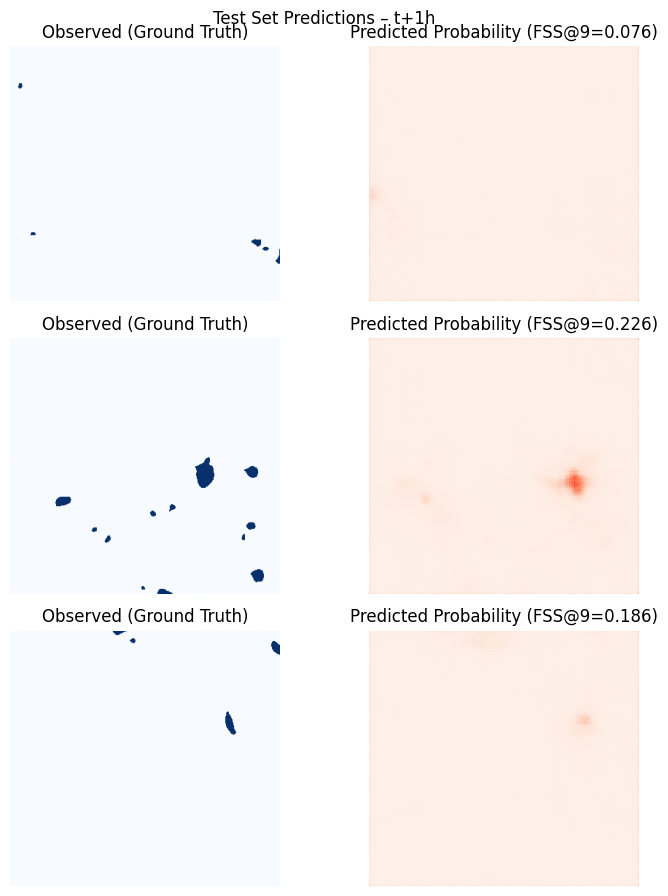

In [ ]:
def plot_predictions(preds, truths, fss_vals, n_samples=3, save_path=None):
    n_samples = min(n_samples, len(preds))
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 3 * n_samples))

    if n_samples == 1:
        axes = [axes]

    for i in range(n_samples):
        pred = preds[i, 0].cpu().numpy()
        truth = truths[i, 0].cpu().numpy()
        fss9_val = fss_vals[i]

        # Observed (true)
        ax_obs = axes[i][0]
        im0 = ax_obs.imshow(truth, cmap="Blues", vmin=0, vmax=1)
        ax_obs.set_title("Observed (Ground Truth)")
        ax_obs.axis("off")

        # Predicted
        ax_pred = axes[i][1]
        im1 = ax_pred.imshow(pred, cmap="Reds", vmin=0, vmax=1)
        ax_pred.set_title(f"Predicted Probability (FSS@9={fss9_val:.3f})")
        ax_pred.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f"Test Set Predictions – t+{LEAD_TIME}h", fontsize=12, y=0.99)
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Saved figure to {save_path}")
    plt.show()

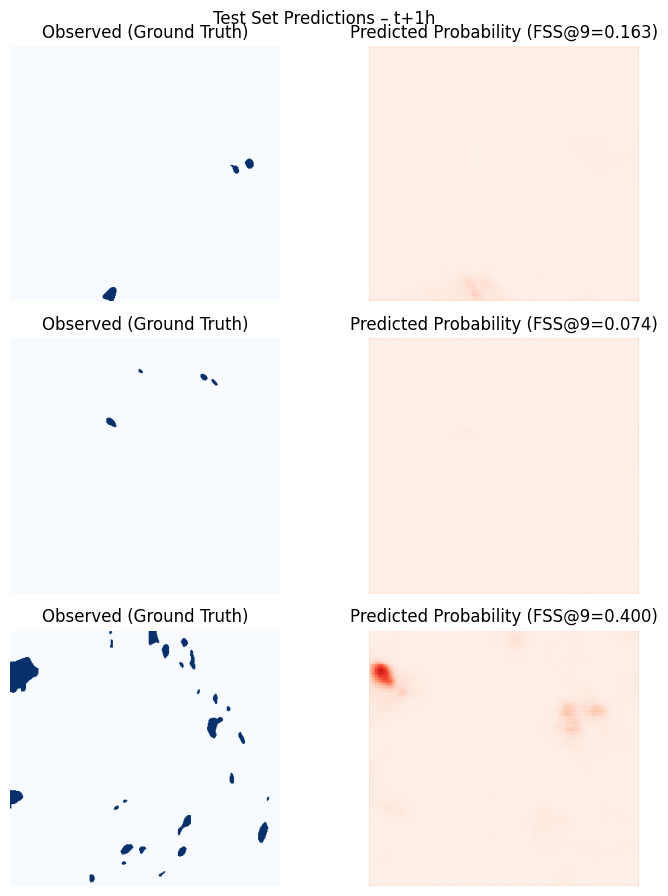

In [31]:
x, g, y = next(iter(test_loader))
x, g, y = x.to(DEVICE), g.to(DEVICE), y.to(DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(model(x, g))

fss_vals = [compute_fss(preds[i:i+1], y[i:i+1], window=9).item() for i in range(len(preds))]

plot_predictions(preds, y, fss_vals, n_samples=3)

FileNotFoundError: [Errno 2] No such file or directory: '/home/users/mendrika/Zambia-Intercomparison/plots/test_roc_t1.png'

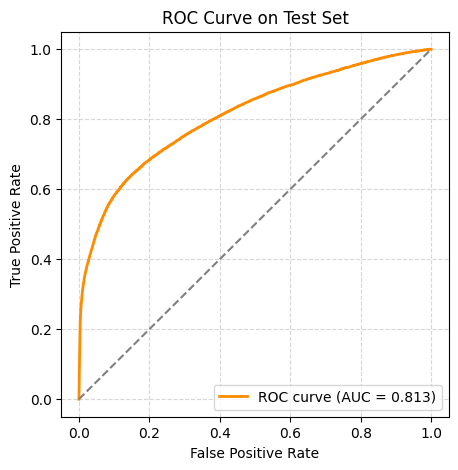

In [32]:
from sklearn.metrics import roc_curve, auc as sk_auc

# Flatten across batches
y_true = y.flatten().cpu().numpy()
y_score = preds.flatten().cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f"/home/users/mendrika/Zambia-Intercomparison/plots/test_roc_t{LEAD_TIME}.png", dpi=150)
plt.show()

print(f"ROC curve saved to /home/users/mendrika/Zambia-Intercomparison/plots/test_roc_t{LEAD_TIME}.png")

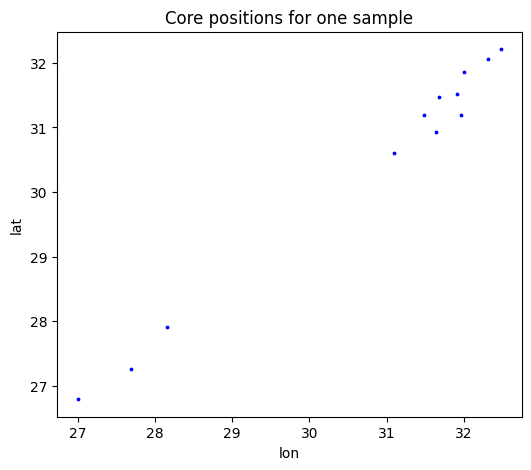

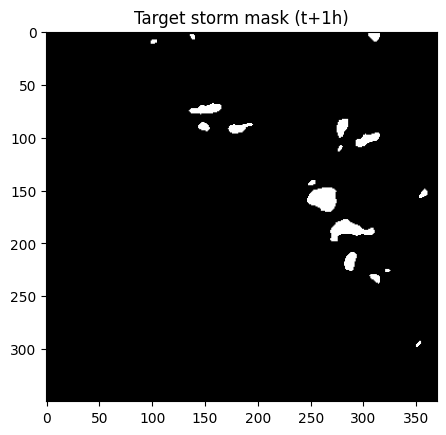

In [4]:
import torch, matplotlib.pyplot as plt

sample = torch.load("/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/shards/t1/train_t1/shard_000.pt", map_location="cpu")
X, G, Y = sample["X"], sample["G"], sample["Y"]

i = 150
mask = X[i, :, 8]
lat  = X[i, :, 4]
lon  = X[i, :, 5]

plt.figure(figsize=(6,5))
plt.scatter(lon[mask>0], lat[mask>0], s=3, c='blue')
plt.title("Core positions for one sample")
plt.xlabel("lon"); plt.ylabel("lat")

plt.figure()
plt.imshow(Y[i], cmap="gray")
plt.title("Target storm mask (t+1h)")
plt.show()


In [7]:
import numpy as np

BASE_DIR = "/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison"
SCALER_PATH = f"{BASE_DIR}/scaling/scaler_realcores.pt"

# Column indices
MASK_COL_INDEX = 8
COLS_TO_SCALE = [0, 1, 2, 3, 4, 5, 6, 7]

# Load scaler
scaler = torch.load(SCALER_PATH, weights_only=False)
mean = np.asarray(scaler["mean"])       # shape (8,)
scale = np.asarray(scaler["scale"])     # shape (8,)


In [8]:
mean

array([ -13.1573589 ,   27.7910228 ,  -13.32466682,  -12.96920525,
         27.56594433,   27.98356172,  -76.54673438, 1474.10843277])

In [9]:
scale

array([   2.86575632,    3.56468299,    2.87983789,    2.85439686,
          3.56120571,    3.56677272,    4.10227839, 2669.53871598])